In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import multivariate_normal

def kernel(s, t):
    return np.exp(-0.5*(s-t)**2/1.**2)

def dXdt(X, t, g):
    return -X + X**2 + g(t)

def dXdt_Jac(X, t):
    return -1 + 2*X

tc = np.array([0., 1., 2., 3., 4., 5.])
Ccc = np.array([[kernel(s, t) for t in tc] for s in tc])
fc = multivariate_normal.rvs(mean=np.zeros(tc.size), cov=Ccc)
Lc = np.linalg.cholesky(Ccc)
Lca = np.linalg.solve(Lc.T, np.linalg.solve(Lc, fc))
def fc_pred(t):
    k = kernel(t, tc)
    return np.dot(k, Lca)
def fc_var(t):
    k11 = kernel(t,t)
    k = kernel(t, tc)
    return k11 - np.dot(k, np.linalg.solve(Lc.T, np.linalg.solve(Lc, k))) 

class condTraj:
    def __init__(self, tc):
        self.tc = tc
        self.Ccc = np.array([[kernel(s, t) for t in tc] for s in tc])
        self.Lc = np.linalg.cholesky(Ccc)

    def sim_f(self):
        self.fc = multivariate_normal.rvs(mean=np.zeros(self.tc.size), cov=self.Ccc)
        self.Lca = np.linalg.solve(self.Lc.T, np.linalg.solve(self.Lc, self.fc))

    def pred_f(self, t):
        k = kernel(t, tc)
        return np.dot(k, self.Lca)
    
    def ode_solve(self,tt,x0):
        sol = odeint(dXdt, x0, tt, args=(self.pred_f,))
        return sol
        
x0 = 0.8
tt = np.linspace(0., 5.)
sol = odeint(dXdt, x0, tt, (fc_pred,))

#fig = plt.figure()
#ax = fig.add_subplot(111)

#mean = [fc_pred(t) for t in tt]
#var = np.array([fc_var(t) for t in tt])
#sd = np.sqrt(var)

#ax.plot(tt, mean)
#ax.fill_between(tt, mean - 2*sd, mean + 2*sd, alpha=0.2)
#plt.show()

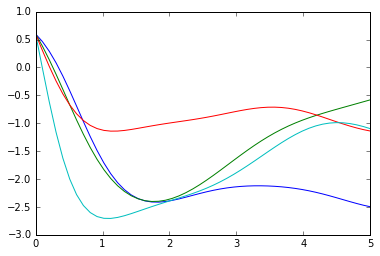

In [64]:
gp = condTraj(tc)
gp.sim_f()

fig2 = plt.figure()
ax = fig2.add_subplot(111)

for nt in range(10):
    gp.sim_f()
    #ax.plot(tt, [gp.pred_f(t) for t in tt])
    sol = gp.ode_solve(tt, x0)
    try:
        if max(abs(sol)) < 10:
            #ax.plot(tt, sol, 'k-.')
            ax.plot(tt, dXdt_Jac(sol, tt))
    except:
        pass
plt.show()